# Making batch predictions using a PyTorch model with Amazon SageMaker
This notebook shows how to make **batch predictions with PyTorch on SageMaker**. Many customers have machine learning workloads that require a large number of predictions to be made reliably on a repeatable schedule. As compared to SageMaker's managed hosting service, compute capacity for batch predictions is spun up on demand and taken down upon completion of the batch. For large batch workloads, this represents significant cost savings over an always-on endpoint. 

Another benefit of SageMaker batch is that it allows data scientists can stay focused on creating the best models.
[SageMaker batch](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) uses the same trained model easily across hosted endpoints and batch, with no need for expensive rewrites or infrastructure. You provide the input via s3, and SageMaker returns the predictions via s3 as well. Note that the same input and output handlers you used for your SageMaker endpoint in the [previous lab](./2_sm_image_classification_birds.ipynb) are used for batch predictions as well. Likewise, the same trained model works for both. 

## Setup
This notebook assumes you have already trained your model in the prior lab, which results in model artifacts being available in S3. Update the `training_job_name` variable below to refer to your specific training job, so that the notebook has a full s3 URI to the model artifacts. 

These same model artifacts were used for deployment in a SageMaker hosted endpoint in the previous lab. In this lab, we demonstrate batch predictions with the same trained model.

In [10]:
import boto3
import sagemaker
from time import gmtime, strftime

training_job_name = '<enter your training job name here>'  ### Replace this with your job name from the previous lab

USE_GPU_INSTANCE  = True
FRAMEWORK_VERSION = '1.3.1'
ACCOUNT_NUM = '763104351884' # for most regions
CONTAINER_NAME = 'pytorch-inference'
print(f'Using account: {ACCOUNT_NUM}, container: {CONTAINER_NAME}')
## Here is the documentation for identifying TensorFlow SageMaker container images
##   https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html

Using account: 763104351884, container: pytorch-inference


In [2]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
s3_prefix = 'DEMO-PYT-image-classification-birds'
region_name = boto3.Session().region_name

To help with evaluating the batch prediction results, enter the list of class labels that your classifier was trained on in notebook 2.

In [3]:
class_name_list = ['013.Bobolink', '017.Cardinal', '035.Purple_Finch', '036.Northern_Flicker']
#,
#                   '047.American_Goldfinch', '068.Ruby_throated_Hummingbird', '073.Blue_Jay', 
#                   '075.Green_Jay', '087.Mallard', '095.Baltimore_Oriole', 
#                   '120.Fox_Sparrow', '179.Tennessee_Warbler', '192.Downy_Woodpecker']

SageMaker batch transformations require input to be specified in s3, and you need to provide an s3 output path where SageMaker will save the resulting predictions. For this sample batch job, we will make a prediction for each of the images from our training dataset.

In [4]:
input_data_path  = f's3://{bucket}/{s3_prefix}/train/'
output_data_path = f's3://{bucket}/{s3_prefix}/batch_predictions/'

print(f'Batch input from: {input_data_path}')
print(f'Batch output to:  {output_data_path}')

Batch input from: s3://sagemaker-us-east-2-355151823911/DEMO-PYT-image-classification-birds/train/
Batch output to:  s3://sagemaker-us-east-2-355151823911/DEMO-PYT-image-classification-birds/batch_predictions/


Before we run the batch transformation, we first remove prior batch prediction results. In production, you would likely instead tag the folder with a timestamp and retain the results from each run of the batch.

In [5]:
!aws s3 ls $input_data_path

                           PRE 013.Bobolink/
                           PRE 017.Cardinal/
                           PRE 035.Purple_Finch/
                           PRE 036.Northern_Flicker/


In [6]:
if input('Are you sure you want to remove the old batch predictions {}?'.format(output_data_path)) == 'yes':
    !aws s3 rm --quiet --recursive $output_data_path

Are you sure you want to remove the old batch predictions s3://sagemaker-us-east-2-355151823911/DEMO-PYT-image-classification-birds/batch_predictions/? no


Likewise, to interpret the results, we copy them down to our local folder. If we have done this before, we first remove the old results.

In [7]:
if input('Are you sure you want to remove the prior local batch predictions from ./batch_predictions') == 'yes':
    !rm -rf ./batch_predictions/*

Are you sure you want to remove the prior local batch predictions from ./batch_predictions no


## Create a Model for performing batch predictions

When we deployed the model in the previous lab to an Amazon SageMaker real time endpoint, we deployed to a CPU-based instance type.  Under the hood a CPU-based Amazon SageMaker Model object was created to wrap a CPU-based TFS container.  However, for Batch Transform on a large dataset, we would prefer to use full GPU instances.  To do this, we need to create another Model object that will utilize a GPU-based TFS container.  

First we give a unique name for the model and identify the proper TensorFlow framework image.

In [12]:
if USE_GPU_INSTANCE:
    device = 'gpu'
    batch_instance_type = 'ml.p3.8xlarge'
else:
    device = 'cpu'
    batch_instance_type = 'ml.c5.4xlarge'

model_artifacts = f's3://{bucket}/{training_job_name}/output/model.tar.gz'
model_prefix = f'pyt-ic-{device}'
model_name = '{}-{}'.format(model_prefix, strftime("%m-%d-%H-%M-%S", gmtime()))
framework_image = \
      f'{ACCOUNT_NUM}.dkr.ecr.{region_name}.amazonaws.com/{CONTAINER_NAME}:{FRAMEWORK_VERSION}-{device}-py3'

print(f'Model will be named: {model_name}')
print('Using image: {}'.format(framework_image))

Model will be named: pyt-ic-gpu-03-02-18-57-20
Using image: 763104351884.dkr.ecr.us-east-2.amazonaws.com/pytorch-inference:1.3.1-gpu-py3


Here we instantiate a Model object pointing to the trained model artifacts and referring to the TensorFlow Serving image that will be used to drive inference on that model.

In [13]:
from sagemaker.pytorch import PyTorchModel

print(f'Creating model for {model_artifacts}')
serving_model = PyTorchModel(model_data=model_artifacts,
                             entry_point='train-resnet.py',
                             source_dir='code',
                             role=sagemaker.get_execution_role(),
                             image=framework_image,
                             framework_version=FRAMEWORK_VERSION,
                             sagemaker_session=sess)
client = boto3.client('sagemaker')
tf_serving_container = serving_model.prepare_container_def(batch_instance_type)
model_params = {
    'ModelName': model_name,
    'Containers': [
        tf_serving_container
    ],
    'ExecutionRoleArn': sagemaker.get_execution_role()
}
client.create_model(**model_params)

Creating model for s3://sagemaker-us-east-2-355151823911/pyt-ic-2020-03-02-17-28-52-529/output/model.tar.gz


{'ModelArn': 'arn:aws:sagemaker:us-east-2:355151823911:model/pyt-ic-gpu-03-02-18-57-20',
 'ResponseMetadata': {'RequestId': '2e2cfcde-c194-4cb9-adf7-c5964fe1b569',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2e2cfcde-c194-4cb9-adf7-c5964fe1b569',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '87',
   'date': 'Mon, 02 Mar 2020 18:57:30 GMT'},
  'RetryAttempts': 0}}

## Launch the batch transformation job
Here we kick off the batch prediction job using the SageMaker Transformer object.

In [15]:
%%time

batch_instance_count = 2
concurrency = 64

transformer = sagemaker.transformer.Transformer(
        model_name=model_name,
        instance_count = batch_instance_count,
        instance_type  = batch_instance_type,
        max_concurrent_transforms = concurrency,
        output_path    = output_data_path,
        base_transform_job_name='pyt-birds-image-transform')

## Alternative API call to get the transformer from the model
# transformer = serving_model.transformer(
#         instance_count = batch_instance_count,
#         instance_type  = batch_instance_type,
#         max_concurrent_transforms = concurrency,
#         output_path    = output_data_path)

transformer.transform(data = input_data_path, content_type = 'application/x-image')
transformer.wait()

..............................
2020-03-02T19:03:39.588:[sagemaker logs]: MaxConcurrentTransforms=16, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
2020-03-02 19:03:39,349 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /opt/conda/lib/python3.6/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 4
Number of CPUs: 32
Max heap size: 27305 M
Python executable: /opt/conda/bin/python
Config file: /etc/sagemaker-mms.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Model Store: /.sagemaker/mms/models
Initial Models: ALL
Log dir: /logs
Metrics dir: /logs
Netty threads: 0
Netty client threads: 0
Default workers per model: 4
Blacklist Regex: N/A
Maximum Response Size: 6553500
Maximum Request Size: 6553500
2020-03-02 19:03:39,405 [INFO ] main com.amazonaws.ml.mms.wlm.ModelManager - Model model loaded.
2020-03-02 19:03:39,421 [INFO ] main com.amazonaws.ml.mms.ModelServer - Initialize Inference server with: Epol

In [16]:
transformer.latest_transform_job.name

'pyt-birds-image-transform-2020-03-02-18-58-48-646'

### Evaluate prediction results
To facilitate evaluation of the output, we download the results to our local folder.

In [17]:
!aws s3 cp  --quiet --recursive $output_data_path ./batch_predictions

Here we take a look at a sample output file. For each jpg file we passed to the batch transformation job, we get a corresponding `.jpg.out` file containing the json formatted output from the prediction.

In [18]:
import glob
filepaths = glob.glob('./batch_predictions/*/*')
print('Total number of predictions: {}'.format(len(filepaths)))
print('\nSample prediction output file:')
sample_file = filepaths[0]
!cat $sample_file

Total number of predictions: 142

Sample prediction output file:
[
  0.047058820724487305,
  0.6855694651603699,
  0.06277478486299515,
  0.2045968472957611
]

For the larger scale batch predictions on images we don't yet have labelled, we'll simply parse the prediction output files to see the distribution of predicted classes.

In [19]:
import json
import re
import os
import glob
import numpy as np

In [20]:
total = 0
predicted = []

for entry in glob.glob('batch_predictions/*/*'):
    try:
        with open(entry, 'r') as f:
            results = json.load(f)
            class_index = np.argmax(np.array(results))
            predicted_label = class_name_list[class_index]
            predicted.append(class_index)
            total += 1
    except Exception as e:
        print(e)
        continue
        
print(f'Found {total} prediction files.')

Found 142 prediction files.


In [21]:
def how_many(in_list, which_value):
    total_found = 0
    for n in range(len(in_list)):
        if in_list[n] == which_value:
            total_found += 1
    return total_found

In [22]:
prediction_totals_by_class = []
for i in range(len(class_name_list)):
    prediction_totals_by_class.append(how_many(predicted, i))

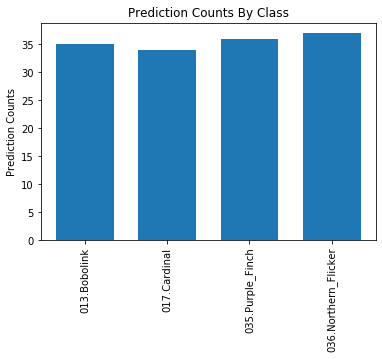

In [23]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

x = np.arange(len(class_name_list))
width = 0.7

fig, ax = plt.subplots()
ax.set_ylabel('Prediction Counts')
ax.set_title('Prediction Counts By Class')
ax.bar(x, prediction_totals_by_class, width)
ax.set_xticks(x)
ax.set_xticklabels(class_name_list, rotation='vertical')
plt.show()

Here we take the highest probability class prediction for each image and compare that to the actual class of the image (represented by its class subfolder).

In [24]:
total = 0
correct = 0

predicted = []
actual = []

for entry in glob.glob('batch_predictions/*/*'):
    try:
        actual_label = entry.split('/')[1]
        actual_index = class_name_list.index(actual_label)
        with open(entry, 'r') as f:
            results = json.load(f)
            class_index = np.argmax(np.array(results))
            predicted_label = class_name_list[class_index]
            predicted.append(class_index)
            actual.append(actual_index)
            is_correct = (predicted_label == actual_label) or False
            if is_correct:
                correct += 1
            total += 1
    except Exception as e:
        print(e)
        continue

In [25]:
print('Out of {} total images, accurate predictions were returned for {}'.format(total, correct))
accuracy = correct / total
print('Accuracy is {:.1%}'.format(accuracy))

Out of 142 total images, accurate predictions were returned for 141
Accuracy is 99.3%


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    plt.figure(figsize=(7,7))
    plt.grid(False)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), 
                                  range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.gca().set_xticklabels(class_name_list)
    plt.gca().set_yticklabels(class_name_list)
    plt.gca().set_ylim(len(class_name_list)-0.5, -0.5) # workaround for matplotlib bug 3.1.1
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
from sklearn.metrics import confusion_matrix
def create_and_plot_confusion_matrix(actual, predicted):
    cnf_matrix = confusion_matrix(actual, np.asarray(predicted),labels=range(len(class_name_list)))
    plot_confusion_matrix(cnf_matrix, classes=range(len(class_name_list)))

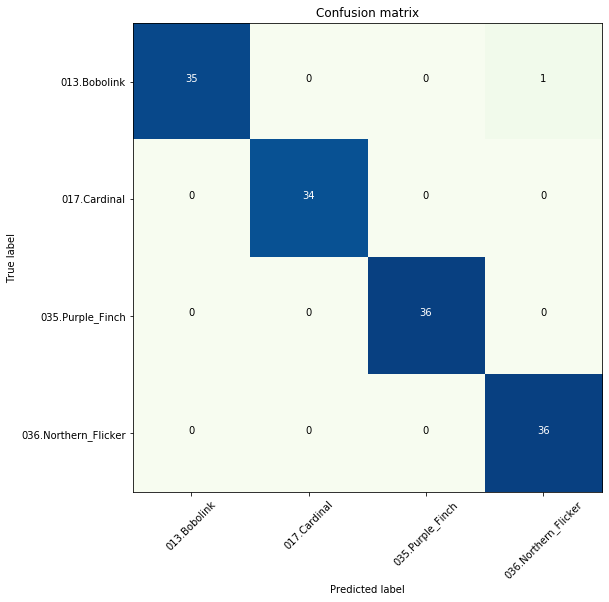

In [28]:
create_and_plot_confusion_matrix(actual, predicted)